## Multilayer Perceptron

In [72]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [44]:
# Hyperparameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 50
batch_size = 100
learning_rate = 0.001

- MNISTはPyTorchの標準機能でデータセットをダウンロードできる
- バッチ単位で読み込めるDataLoaderも簡単に使える

In [60]:
# MNIST Dataset (Images and Labels)
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [61]:
print(len(train_dataset))  # 60000
print(len(test_dataset))   # 10000

60000
10000


- DataLoaderから1バッチ分のデータを取り出す方法
- DataLoaderをiterで囲んでnext()すればよい

In [65]:
# 1データだけ取得
image, label = iter(train_loader).next()
print(type(image))   # <class 'torch.FloatTensor'>
print(type(label))   # <class 'torch.LongTensor'>
print(image.size())  # torch.Size([100, 1, 28, 28])
print(label.size())  # torch.Size([100])

<class 'torch.FloatTensor'>
<class 'torch.LongTensor'>
torch.Size([100, 1, 28, 28])
torch.Size([100])


(-0.5, 145.5, 145.5, -0.5)

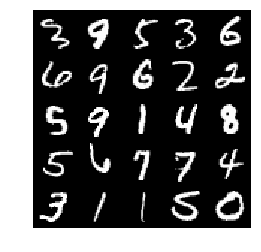

In [74]:
# 可視化
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(train_loader).next()
images, labels = images[:25], labels[:25]
imshow(torchvision.utils.make_grid(images, nrow=5, padding=1))
plt.axis('off')

In [66]:
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
#         print(x.size())
        out = self.fc1(x)
#         print(out.size())
        out = self.relu(out)
#         print(out.size())
        out = self.fc2(out)
#         print(out.size())
        return out

- Sequentialを使ってまとめて書く方法もある
- forward処理中に出力値を見られる

In [67]:
model = MultiLayerPerceptron(input_size, hidden_size, num_classes)

In [68]:
# テスト
image, label = iter(train_loader).next()
print("befire view:", image.size())
image = image.view(-1, 28 * 28)
print("after view:", image.size())
model(Variable(image))

befire view: torch.Size([100, 1, 28, 28])
after view: torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 500])
torch.Size([100, 500])
torch.Size([100, 10])


Variable containing:
 0.0881  0.1128  0.1229  ...   0.0547  0.1134  0.0740
 0.1181  0.0273  0.0997  ...   0.0352  0.0604  0.0261
 0.0704  0.0372  0.0514  ...  -0.1734  0.1685  0.2151
          ...             ⋱             ...          
 0.0005  0.0968 -0.0255  ...   0.0411  0.0099  0.0492
-0.0076  0.0129  0.0341  ...  -0.0539  0.1071  0.0137
 0.1145  0.0278  0.0273  ...   0.0387  0.1142  0.0560
[torch.FloatTensor of size 100x10]

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [52]:
def train(train_loader):
    model.train()
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss

        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    
    return train_loss.data[0]


def valid(test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels.data).sum()
        total += labels.size(0)

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    
    return val_loss.data[0], val_acc


loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)

    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
          % (epoch, loss, val_loss, val_acc))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 2.2311 val_loss: 2.1544 val_acc: 0.5560
epoch 1, loss: 2.0792 val_loss: 1.9867 val_acc: 0.6899
epoch 2, loss: 1.8992 val_loss: 1.7872 val_acc: 0.7371
epoch 3, loss: 1.6928 val_loss: 1.5692 val_acc: 0.7641
epoch 4, loss: 1.4803 val_loss: 1.3590 val_acc: 0.7839
epoch 5, loss: 1.2863 val_loss: 1.1779 val_acc: 0.8020
epoch 6, loss: 1.1248 val_loss: 1.0329 val_acc: 0.8172
epoch 7, loss: 0.9973 val_loss: 0.9203 val_acc: 0.8262
epoch 8, loss: 0.8981 val_loss: 0.8330 val_acc: 0.8360
epoch 9, loss: 0.8207 val_loss: 0.7645 val_acc: 0.8446
epoch 10, loss: 0.7593 val_loss: 0.7099 val_acc: 0.8502
epoch 11, loss: 0.7097 val_loss: 0.6653 val_acc: 0.8558
epoch 12, loss: 0.6690 val_loss: 0.6287 val_acc: 0.8618
epoch 13, loss: 0.6351 val_loss: 0.5977 val_acc: 0.8658
epoch 14, loss: 0.6063 val_loss: 0.5715 val_acc: 0.8692
epoch 15, loss: 0.5816 val_loss: 0.5488 val_acc: 0.8724
epoch 16, loss: 0.5602 val_loss: 0.5290 val_acc: 0.8745
epoch 17, loss: 0.5415 val_loss: 0.5118 val_acc: 0.8780
ep

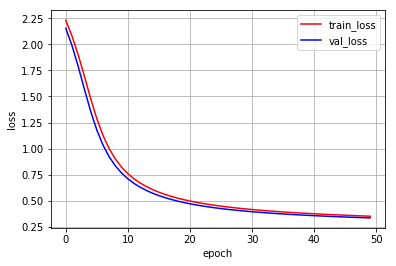

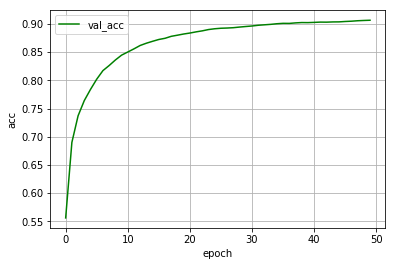

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()